# State estimation with unknown $\mathbf{A}$ and $\gamma$
## Model specification
$$p(\mathbf{x, y, a, \gamma}) = p(\mathbf{x}_0)p(\mathbf{a})p(\gamma_x)p(\gamma_y)\prod_{n=1}^Np(\mathbf{x}_n|\mathbf{x}_{n-1}, \mathbf{a, \gamma_x})p(y_n|\mathbf{x}_n, \gamma_y)$$

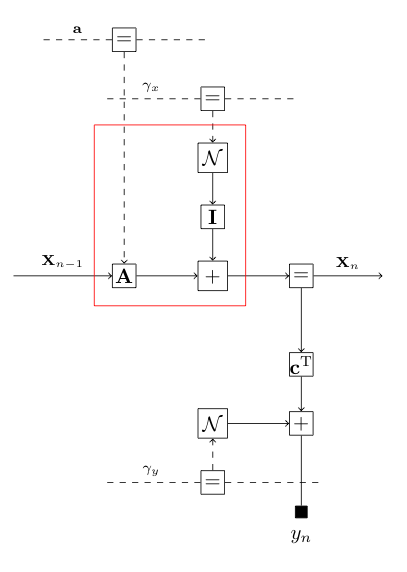

In [28]:
using Images
img = load("../ffgs/HAR-online.png")

The central quantity of our interest is a joint estimation of the AR coefficients $\mathbf{a}$, the precision  of the driving noise $\gamma_x$ and the states $\mathbf{x}_n$, $\mathbf{x}_{n-1}$.

In [29]:
using ForneyLab
using Plots
import ARdata: use_data, generate_data
import LinearAlgebra: I, Symmetric
import ForneyLab: unsafeCov, unsafeMean, unsafePrecision

In [30]:
# Define the order of AR model
ARorder = UInt16(10)
diagAR(dim) = Matrix{Float64}(I, dim, dim)
# Real state and preprocessing
x = use_data("/Users/albertpod/Documents/Julia/VariationalBayes/data/daily-minimum-temperatures.csv", ARorder)
[reverse!(x) for x in x]
# Noisy observations
y = [x .+ 0.1 for x in x]
y[1:5]

5-element Array{Array{Float64,1},1}:
 [20.1, 21.9, 17.5, 15.9, 15.9, 15.9, 14.7, 18.9, 18.0, 20.8]
 [16.3, 20.1, 21.9, 17.5, 15.9, 15.9, 15.9, 14.7, 18.9, 18.0]
 [13.4, 16.3, 20.1, 21.9, 17.5, 15.9, 15.9, 15.9, 14.7, 18.9]
 [16.8, 13.4, 16.3, 20.1, 21.9, 17.5, 15.9, 15.9, 15.9, 14.7]
 [21.6, 16.8, 13.4, 16.3, 20.1, 21.9, 17.5, 15.9, 15.9, 15.9]

In [31]:
# Building the model
g = FactorGraph()

# declare priors as random variables
@RV m_x_t_prev
@RV w_x_t_prev
@RV m_x_t
@RV w_x_t
@RV a_w_t
@RV b_w_t
@RV m_a_t
@RV w_a_t

@RV a ~ GaussianMeanPrecision(m_a_t, w_a_t)
@RV x_t_prev ~ GaussianMeanPrecision(m_x_t_prev, w_x_t_prev)
@RV w ~ Gamma(a_w_t, b_w_t)
@RV x_t ~ GaussianMeanPrecision(m_x_t, w_x_t)
Autoregression(x_t, x_t_prev, a, w)
@RV n ~ GaussianMeanVariance(0*rand(ARorder), 0.1*diagAR(ARorder))
@RV y_t = x_t + n

# Placeholders for prior
placeholder(m_x_t_prev, :m_x_t_prev, dims=(ARorder,))
placeholder(w_x_t_prev, :w_x_t_prev, dims=(ARorder, ARorder))
placeholder(m_x_t, :m_x_t, dims=(ARorder,))
placeholder(w_x_t, :w_x_t, dims=(ARorder, ARorder))
placeholder(a_w_t, :a_w_t)
placeholder(b_w_t, :b_w_t)
placeholder(m_a_t, :m_a_t, dims=(ARorder,))
placeholder(w_a_t, :w_a_t, dims=(ARorder, ARorder))

# Placeholder for data
placeholder(y_t, :y_t, dims=(ARorder,));

In [32]:
# Specify recognition factorization
q = RecognitionFactorization(a, x_t_prev, x_t, w, ids=[:A, :X_t_prev, :X_t, :W])
# Generate the variational update algorithms for each recognition factor
algo = variationalAlgorithm(q)
# Load algorithms
eval(Meta.parse(algo));

RecognitionFactor[RecognitionFactor(:A, Set(Variable[Variable(:a, Edges:
Edge belonging to variable a: ( gaussianmeanprecision_1.i[out] )----( autoregression_1.i[a] ).
)]), Set(ForneyLab.Cluster[]), Edges:
Edge belonging to variable a: ( gaussianmeanprecision_1.i[out] )----( autoregression_1.i[a] ).
)]
FactorNodes:
Autoregression with id autoregression_1
GaussianMeanPrecision with id gaussianmeanprecision_1

Symbol[:A, :agaussianmeanprecision_1bplaceholder_m_a_t, :agaussianmeanprecision_1bplaceholder_w_a_t]
Symbol[:X_t, :X_t_prev, :A, :W]
1.	NaiveVariationalRule{GaussianMeanPrecision} on Interface 1 (out) of GaussianMeanPrecision gaussianmeanprecision_1
2.	NaiveVariationalRule{Autoregression} on Interface 3 (a) of Autoregression autoregression_1

RecognitionFactor[RecognitionFactor(:X_t_prev, Set(Variable[Variable(:x_t_prev, Edges:
Edge belonging to variable x_t_prev: ( gaussianmeanprecision_2.i[out] )----( autoregression_1.i[x] ).
)]), Set(ForneyLab.Cluster[]), Edges:
Edge belonging t

In [33]:
# Define values for prior statistics
m_x_prev_0 = 100.0*rand(ARorder)
w_x_prev_0 = (tiny*diagAR(ARorder))
m_x_0 = 100.0*rand(ARorder)
w_x_0 = (tiny*diagAR(ARorder))
a_w_0 = 20
b_w_0 = 1
m_a_0 =  10.0*rand(ARorder)
w_a_0 = (tiny*diagAR(ARorder));

In [34]:
# Storage
m_x_prev = Vector{Vector{Float64}}(undef, length(x))
w_x_prev = Vector{Array{Float64, 2}}(undef, length(x))
m_x = Vector{Vector{Float64}}(undef, length(x))
w_x = Vector{Array{Float64, 2}}(undef, length(x))
a_w = Vector{Float64}(undef, length(x))
b_w = Vector{Float64}(undef, length(x))
m_a = Vector{Vector{Float64}}(undef, length(x))
w_a = Vector{Array{Float64, 2}}(undef, length(x))

# Inits
m_x_t_prev_min = m_x_prev_0
w_x_t_prev_min = w_x_prev_0
m_x_t_min = m_x_0
w_x_t_min = w_x_0
a_w_t_min = a_w_0
b_w_t_min = b_w_0
m_a_t_min = m_a_0
w_a_t_min = w_a_0;

In [35]:
marginals = Dict()
n_its = 10
for t = 1:length(y)
    #println("Observation # ", t)
    marginals[:a] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_a_t_min, w=w_a_t_min)
    marginals[:x_t_prev] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_x_t_prev_min, w=w_x_t_prev_min)
    marginals[:x_t] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_x_t_min, w=w_x_t_min)
    marginals[:w] = ProbabilityDistribution(Univariate, Gamma, a=a_w_t_min, b=b_w_t_min)
    
    global m_x_t_prev_min, w_x_t_prev_min, m_x_t_min, w_x_t_min,
           a_w_t_min, b_w_t_min, m_a_t_min, w_a_t_min
    
    for i = 1:n_its

        data = Dict(:y_t   => y[t],
                    :m_a_t => m_a_t_min,
                    :w_a_t => w_a_t_min,
                    :m_x_t_prev => m_x_t_prev_min,
                    :w_x_t_prev => w_x_t_prev_min,
                    :m_x_t => m_x_t_min,
                    :w_x_t => w_x_t_min,
                    :a_w_t => a_w_t_min,
                    :b_w_t => b_w_t_min)
        #display(data)
        stepA!(data, marginals)
        stepW!(data, marginals)
        stepX_t!(data, marginals)
        stepX_t_prev!(data, marginals)

    end
    # Extract posterior statistics
    m_a[t] = unsafeMean(marginals[:a])
    w_a[t] = unsafePrecision(marginals[:a])
    m_x[t] = unsafeMean(marginals[:x_t])
    w_x[t] = unsafePrecision(marginals[:x_t])
    m_x_prev[t] = unsafeMean(marginals[:x_t_prev])
    w_x_prev[t] = unsafePrecision(marginals[:x_t_prev])
    a_w[t] = marginals[:w].params[:a]
    b_w[t] = marginals[:w].params[:b]
    # Store to buffer
    m_a_t_min = m_a[t]
    w_a_t_min = w_a[t]
    m_x_t_prev_min = m_x_prev[t]
    w_x_t_prev_min = w_x_prev[t]
    m_x_t_min = m_x[t]
    w_x_t_min = w_x[t]
    a_w_t_min = a_w[t]
    b_w_t_min = b_w[t]
end

In [36]:
from = length(x) - 1000
predicted = [x[1] for x in m_x[1:end]]
noise = [y[1] for y in y[1:end]]
actual = [x[1] for x in x[1:end]]
mse = (sum((predicted - actual).^2))/length(predicted)

16.445387503893787

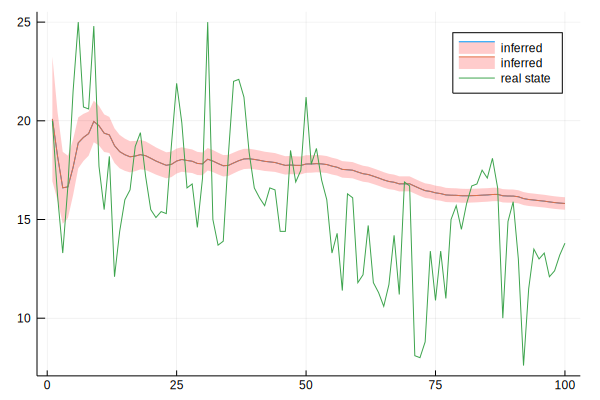

In [37]:
v_x = [v_x[1]^-1 for v_x in w_x] # variance
upto = 100#length(x)
scale = 10
plot([predicted[1:upto], predicted[1:upto]], fillrange=[predicted[1:upto]- scale .* sqrt.(v_x[1:upto]),predicted[1:upto]+ scale .* sqrt.(v_x[1:upto])],
     fillalpha = 0.2,
     fillcolor = :red,
     label=["inferred", "inferred"])
#plot!(noise[1:upto], label="noise")
plot!(actual[1:upto], label="real state")